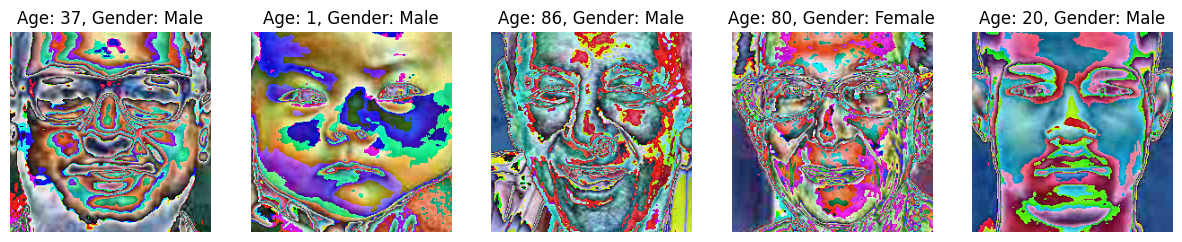

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
from sklearn.model_selection import train_test_split
import random
import os
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomAgeGenderDataset(Dataset):
    def __init__(self, root_dir, image_files, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        age, gender = map(int, image_file.split('_')[:2])  # Extract age and gender from the file name
        # Normalize gender to 0 for male and 1 for female
        gender = 1 if gender == 1 else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, age, gender

# Create a CNN model
class AgeGenderPredictionModel(nn.Module):
    def __init__(self):
        super(AgeGenderPredictionModel, self).__init__()
        self.features = models.resnet18(pretrained=True)
        
        num_features = self.features.fc.in_features
        self.features.fc = nn.Identity()  # Remove the fully connected layer

        # age prediction
        self.fc_age = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # gender prediction
        self.fc_gender = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        age = self.fc_age(x)
        gender = torch.sigmoid(self.fc_gender(x))  # Sigmoid activation for binary gender prediction
        return age, gender

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load all of the image paths
image_files = [fname for fname in os.listdir('C:\\Users\\alans\\Datasets\\utkcropped') if fname.endswith('.jpg')]

# number of total images and the number of images to use
total_images = len(image_files)  
num_images = 20000  ################################## up to 23000, adjust as you want

# select a random subset
selected_files = random.sample(image_files, num_images)

# split the selected files into train and test sets
train_files, test_files = train_test_split(selected_files, test_size=0.2, random_state=42)

# use custom datasets for train and test sets
train_dataset = CustomAgeGenderDataset(root_dir='C:\\Users\\alans\\Datasets\\utkcropped', image_files=train_files, transform=transform)
test_dataset = CustomAgeGenderDataset(root_dir='C:\\Users\\alans\\Datasets\\utkcropped', image_files=test_files, transform=transform)

# define the dataloaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
sample_batch = next(iter(sample_loader))

plt.figure(figsize=(15, 5))
for i in range(len(sample_batch[0])):
    image, age, gender = sample_batch[0][i], sample_batch[1][i], sample_batch[2][i]
    plt.subplot(1, 5, i+1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f"Age: {age}, Gender: {'Female' if gender == 1 else 'Male'}")
    plt.axis('off')
plt.show()

In [11]:


# initialize model, loss function, and optimizer
model = AgeGenderPredictionModel().to(device)
criterion_age = nn.MSELoss()
criterion_gender = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and MAE values
train_loss_age_values = []
train_loss_gender_values = []
test_loss_age_values = []  
test_loss_gender_values = []
test_mae_age_values = []
test_mae_gender_values = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss_age = 0.0
    running_loss_gender = 0.0
    model.train() 
    for images, ages, genders in train_loader:
        images, ages, genders = images.to(device), ages.to(device), genders.to(device)  # Move to device
        optimizer.zero_grad()
        predicted_ages, predicted_genders = model(images)
        loss_age = criterion_age(predicted_ages, ages.float().unsqueeze(1))
        loss_gender = criterion_gender(predicted_genders, genders.float().unsqueeze(1))
        loss = loss_age + loss_gender  
        loss.backward()
        optimizer.step()
        running_loss_age += loss_age.item()
        running_loss_gender += loss_gender.item()
    train_loss_age_values.append(running_loss_age/len(train_loader))
    train_loss_gender_values.append(running_loss_gender/len(train_loader))
    print(f"Epoch {epoch+1}, Train Loss (Age): {train_loss_age_values[-1]}, Train Loss (Gender): {train_loss_gender_values[-1]}")

    # Evaluate the model after each epoch
    model.eval()  
    total_loss_age = 0.0
    total_loss_gender = 0.0
    total_absolute_error_age = 0.0
    total_absolute_error_gender = 0.0
    num_samples = 0
    
    with torch.no_grad():  
        for images, ages, genders in test_loader:
            images, ages, genders = images.to(device), ages.to(device), genders.to(device)  # Move to device
            predicted_ages, predicted_genders = model(images)
            absolute_error_age = torch.abs(predicted_ages - ages.float().unsqueeze(1))
            absolute_error_gender = torch.abs(predicted_genders - genders.float().unsqueeze(1))
            total_absolute_error_age += torch.sum(absolute_error_age).item()
            total_absolute_error_gender += torch.sum(absolute_error_gender).item()
            loss_age = criterion_age(predicted_ages, ages.float().unsqueeze(1))
            loss_gender = criterion_gender(predicted_genders, genders.float().unsqueeze(1))
            total_loss_age += loss_age.item() * len(images)
            total_loss_gender += loss_gender.item() * len(images)
            num_samples += len(images)
    
    mean_loss_age = total_loss_age / num_samples
    mean_loss_gender = total_loss_gender / num_samples
    mean_absolute_error_age = total_absolute_error_age / num_samples
    mean_absolute_error_gender = total_absolute_error_gender / num_samples
    
    test_loss_age_values.append(mean_loss_age)
    test_loss_gender_values.append(mean_loss_gender)
    test_mae_age_values.append(mean_absolute_error_age)
    test_mae_gender_values.append(mean_absolute_error_gender)

    # Print mean loss and MAE for age and gender predictions after each epoch
    print(f"Mean Loss on Test Set (Age): {mean_loss_age}")
    print(f"Mean Loss on Test Set (Gender): {mean_loss_gender}")
    print(f"Mean Absolute Error on Test Set (Age): {mean_absolute_error_age}")
    print(f"Mean Absolute Error on Test Set (Gender): {mean_absolute_error_gender}")


Epoch 1, Train Loss (Age): 152.50428492736816, Train Loss (Gender): 0.6684957143068314
Mean Loss on Test Set (Age): 121.6644755859375
Mean Loss on Test Set (Gender): 0.646480408191681
Mean Absolute Error on Test Set (Age): 7.969399517059326
Mean Absolute Error on Test Set (Gender): 0.4487751069068909
Epoch 2, Train Loss (Age): 88.71422575759888, Train Loss (Gender): 0.6716216282844544
Mean Loss on Test Set (Age): 86.47411044311524
Mean Loss on Test Set (Gender): 0.664827760219574
Mean Absolute Error on Test Set (Age): 7.1188785896301265
Mean Absolute Error on Test Set (Gender): 0.4673575069904327
Epoch 3, Train Loss (Age): 72.83941550064087, Train Loss (Gender): 0.6268029028773308
Mean Loss on Test Set (Age): 65.30537980651856
Mean Loss on Test Set (Gender): 0.5949986474514007
Mean Absolute Error on Test Set (Age): 5.873570011138916
Mean Absolute Error on Test Set (Gender): 0.4215127096176147
Epoch 4, Train Loss (Age): 59.71881653213501, Train Loss (Gender): 0.6061272543668746
Mean Los

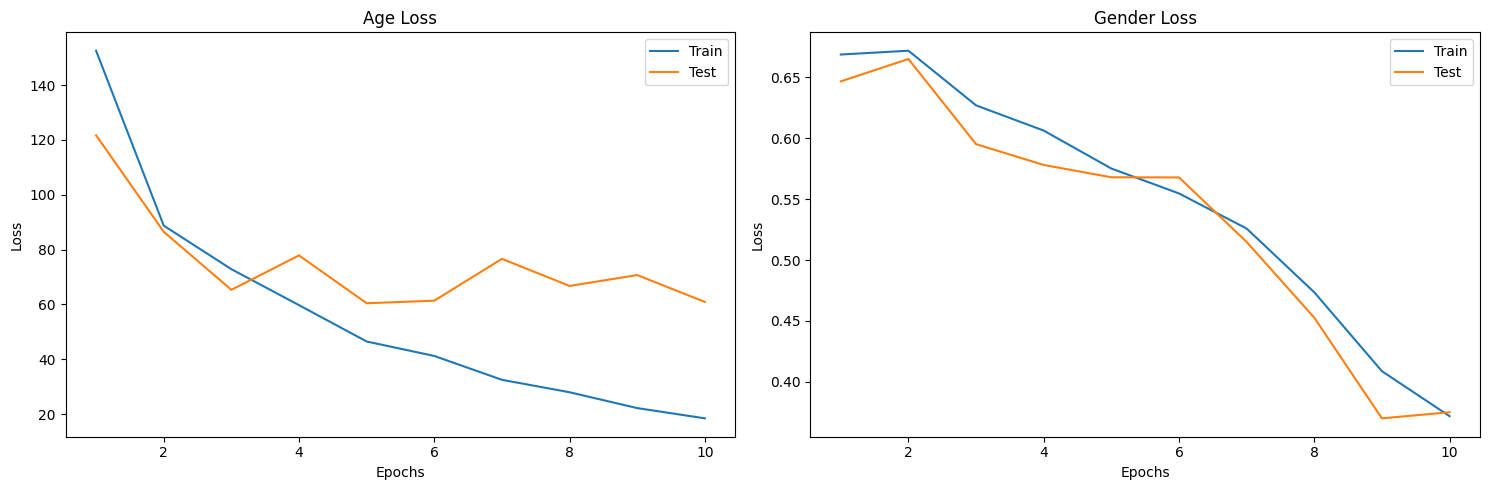

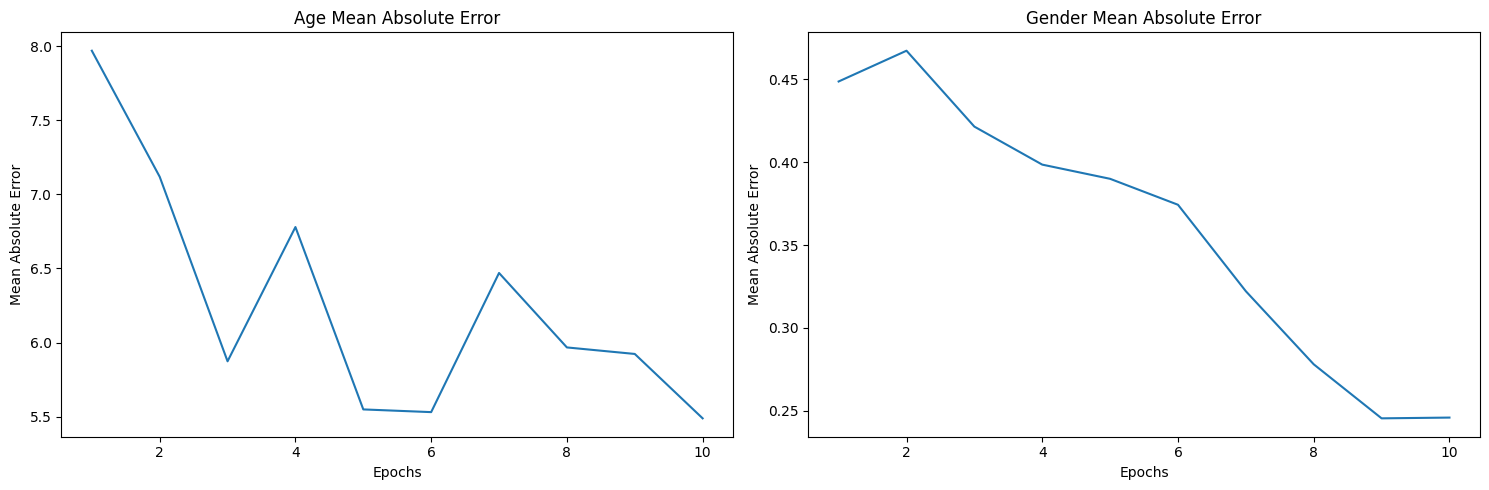

In [12]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_age_values, label='Train')
plt.plot(epochs, test_loss_age_values, label='Test')
plt.title('Age Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_gender_values, label='Train')
plt.plot(epochs, test_loss_gender_values, label='Test')
plt.title('Gender Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, test_mae_age_values)
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 2, 2)
plt.plot(epochs, test_mae_gender_values)
plt.title('Gender Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()